In [1]:
# MNIST with an MLP, from scratch

# - Step 1: build an MLP from scratch to solve MNIST. Question set: https://fleuret.org/dlc/materials/dlc-practical-3.pdf
# - Step 2: debug your network with backprop ninja and a reference implementation using torch's .backward()
# - Step 3: build the same MLP but will full pytorch code (nn.Linear, etc.)

In [2]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from utils import load_data

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [5]:
train_input.shape

torch.Size([1000, 784])

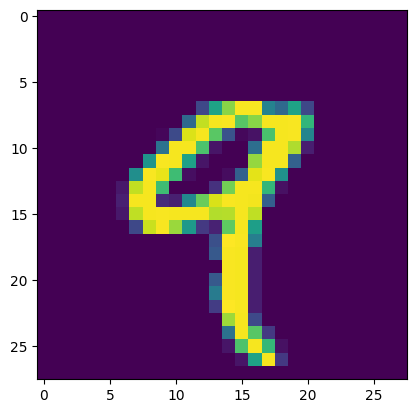

In [6]:
plt.imshow(train_input[4].view((28,28)))

In [7]:
def compute_accuracy (preds, targets):
    """ Computes the accuracy between predictions and targets. Data is expected to be one-hot encoded. """
    _, idx1 = torch.max(preds, dim=1)
    _, idx2 = torch.max(targets, dim=1)
    d = idx1 == idx2
    return d.int().float().mean().item()

In [8]:
# unit test
preds = torch.zeros((4,7))
preds[0,1] = 1
preds[1,4] = 1
preds[2,2] = 1
preds[3,6] = 1
targets = torch.zeros((4,7))
targets[0,1] = 1
targets[1,4] = 1
targets[2,2] = 1
targets[3,2] = 1
compute_accuracy(preds, targets)

0.75

In [9]:
def sigma(x):
    return torch.tanh(x)

def dsigma(x):
    return (1.0 - torch.tanh(x)**2)

In [10]:
def loss (v,t):
    out = torch.sum(torch.pow(v-t, 2))
    return out

def dloss(v,t):
    return -2.0 * (t-v)

In [11]:
v = torch.randn((3, 6), dtype=torch.float32)
t = torch.randn((3, 6), dtype=torch.float32)
l=loss(v,t)
dloss(v,t)

tensor([[ 1.2605,  2.9888,  3.5522, -4.2223,  0.2682,  4.3774],
        [ 2.1808, -0.4118, -1.7997,  2.7460, -0.7801, -3.3120],
        [ 6.6432,  5.3379,  1.0165, -0.1707, -2.7271,  0.8778]])

In [12]:
# multiply targets by 0.9 to be in the range of tanh
train_target *= 0.9
test_target *= 0.9

### Step 1: Backprop ninja

In [13]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [14]:
torch.manual_seed(1337)
w1 = torch.randn((784, 50))
b1 = torch.randn((50))
w2 = torch.randn((50, 10))
b2 = torch.randn((10))
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad = True

In [15]:
x1 = train_input[:5]
y1 = train_target[:5]
z1 = x1 @ w1 + b1
h1 = sigma(z1)
z2 = h1 @ w2 + b2
h2 = sigma(z2)
l = loss(h2, y1)
h2.shape, l

(torch.Size([5, 10]), tensor(43.2825, grad_fn=<SumBackward0>))

In [16]:
others = [h2,z2,h1,z1]
for p in parameters:
    p.grad = None
for t in others:
    t.retain_grad()
l.backward()
print(f'loss={l}')

loss=43.282527923583984


In [17]:
b2.grad.shape

torch.Size([10])

In [18]:
u = torch.randn((50,))
z1.shape
#(z1 + torch.randn((50,))).shape

torch.Size([5, 50])

In [19]:
# here we compare our gradient to the reference gradient computed by pytorch
dl = 1.0
dh2 = dloss(h2, y1) * dl
dh2.shape
cmp('h2',dh2,h2)
dz2 = dsigma(z2) * dh2
dz2.shape
cmp('z2',dz2, z2)
dw2 = h1.T @ dz2
cmp('w2',dw2, w2)
db2 = dz2.sum(0, keepdim=True)
#print(b2.shape)
cmp('b2',db2, b2)
dh1 = dz2 @ w2.T
cmp('h1',dh1, h1)
dz1 = dsigma(z1) * dh1
cmp('z1', dz1, z1)
dw1 = x1.T @ dz1
cmp('w1', dw1, w1)
db1 = dz1.sum(0, keepdim=True)
cmp('b1', db1, b1)


h2              | exact: True  | approximate: True  | maxdiff: 0.0
z2              | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h1              | exact: True  | approximate: True  | maxdiff: 0.0
z1              | exact: True  | approximate: True  | maxdiff: 0.0
w1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [20]:
lr = 0.1
with torch.no_grad():
    w1 += -lr * dw1
    b1 += -lr * db1.squeeze()
    w2 += -lr * dw2
    b2 += -lr * db2.squeeze()

In [21]:
l = loss(h2, y1)
l.item()

43.282527923583984

##### Now that we've checked our gradients are correct, we can implement the network

In [22]:
def forward(w1, b1, w2, b2, x):
    z1 = x @ w1 + b1
    h1 = sigma(z1)
    z2 = h1 @ w2 + b2
    h2 = sigma(z2)
    return z1, h1, z2, h2


In [23]:
def backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1):
    dl = 1.0
    dh2 = dloss(h2, y1) * dl
    dz2 = dsigma(z2) * dh2
    dw2 = h1.T @ dz2
    db2 = dz2.sum(0, keepdim=True)
    dh1 = dz2 @ w2.T
    dz1 = dsigma(z1) * dh1
    dw1 = x1.T @ dz1
    db1 = dz1.sum(0, keepdim=True)
    return dw1, db1, dw2, db2

In [24]:
def update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr):
    with torch.no_grad():
        w1 += -lr * dw1
        b1 += -lr * db1.squeeze()
        w2 += -lr * dw2
        b2 += -lr * db2.squeeze()
    return w1, b1, w2, b2

In [25]:
def init():
    """ init a network """
    torch.manual_seed(1337)
    istd = math.sqrt(1e-6)
    w1 = torch.zeros((784, 50))
    torch.nn.init.normal_(w1, mean=.0, std=istd)
    b1 = torch.zeros((50,))
    w2 = torch.zeros((50, 10))
    torch.nn.init.normal_(w2, mean=.0, std=istd)
    b2 = torch.zeros((10,))
    return w1, b1, w2, b2

In [26]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [27]:
train_input.shape

torch.Size([1000, 784])

In [28]:
# main training loop
torch.set_printoptions(linewidth=200)
def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        #print(f'{num_samples=}')
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        lsi = loss(h2, yb)
        # backward
        dw1, db1, dw2, db2 = backward(w1, b1, w2, b2, xb, yb, h2, z2, h1, z1)
        # update
        lr = 0.1 / num_samples if step < 5000 else 0.01 / num_samples
        w1, b1, w2, b2 = update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr)
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

        
    

In [29]:
lossi = train(w1, b1, w2, b2)


step = 0, loss = 809.9498291015625
step = 100, loss = 288.3344421386719
step = 200, loss = 188.25146484375
step = 300, loss = 135.74131774902344
step = 400, loss = 111.4034652709961
step = 500, loss = 108.89515686035156
step = 600, loss = 81.62015533447266
step = 700, loss = 72.11908721923828
step = 800, loss = 63.931785583496094
step = 900, loss = 68.5213394165039
step = 1000, loss = 57.91291809082031
step = 1100, loss = 57.774803161621094
step = 1200, loss = 48.503173828125
step = 1300, loss = 50.216487884521484
step = 1400, loss = 44.802391052246094
step = 1500, loss = 37.05268859863281
step = 1600, loss = 38.78538131713867
step = 1700, loss = 36.943973541259766
step = 1800, loss = 29.76604461669922
step = 1900, loss = 29.955276489257812
step = 2000, loss = 29.7383975982666
step = 2100, loss = 27.405160903930664
step = 2200, loss = 22.288021087646484
step = 2300, loss = 30.85781478881836
step = 2400, loss = 21.275697708129883
step = 2500, loss = 23.105621337890625
step = 2600, loss 

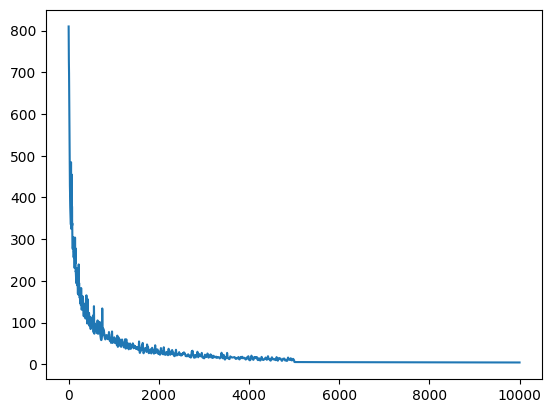

In [30]:
plt.plot(lossi)
#print(lossi)

### Step 2: Reference implementation using pytorch's .backward()

In [31]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [32]:
# reference code
torch.set_printoptions(linewidth=200)
import torch.nn as F

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        xloss = F.MSELoss()
        lsi = xloss(h2, yb) * yb.nelement()
        # backward
        for p in parameters:
            p.grad = None
        lsi.backward()
        # update
        lr = 0.1 / num_samples
        for p in parameters:
            p.data += -lr * p.grad
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [33]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 809.9498901367188
step = 100, loss = 288.28369140625
step = 200, loss = 184.11080932617188
step = 300, loss = 160.19264221191406
step = 400, loss = 107.85164642333984
step = 500, loss = 95.93726348876953
step = 600, loss = 93.2559585571289
step = 700, loss = 97.03384399414062
step = 800, loss = 70.87261199951172
step = 900, loss = 62.282379150390625
step = 1000, loss = 53.30959701538086
step = 1100, loss = 58.90336990356445
step = 1200, loss = 39.89829635620117
step = 1300, loss = 45.262142181396484
step = 1400, loss = 44.16379928588867
step = 1500, loss = 33.67974090576172
step = 1600, loss = 37.013328552246094
step = 1700, loss = 36.373382568359375
step = 1800, loss = 42.787803649902344
step = 1900, loss = 35.408042907714844
step = 2000, loss = 37.09584426879883
step = 2100, loss = 26.44915771484375
step = 2200, loss = 28.030025482177734
step = 2300, loss = 27.747295379638672
step = 2400, loss = 21.42892074584961
step = 2500, loss = 19.893863677978516
step = 2600, lo

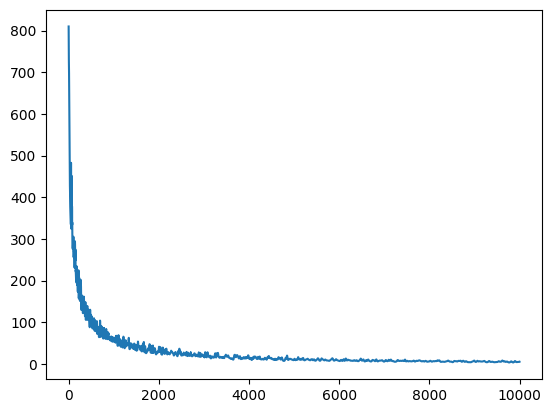

In [34]:
plt.plot(lossi)

### Step 3: Build the same MLP layer but with fully pytorch code (nn.Linear(), etc.)

In [35]:
# network dimensions
n_in = 784
n_hidden = 200
n_out = 10

In [36]:
X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

In [37]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(n_in, n_hidden, bias=True),
            nn.Tanh(),
            nn.Linear(n_hidden, n_out, bias=True), 
            nn.Tanh(), 
        ))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [38]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')




step =      0	loss=0.14046	accuracy (train, test): 0.11500	0.19800
step =   1000	loss=0.00010	accuracy (train, test): 1.00000	0.87300
step =   2000	loss=0.00005	accuracy (train, test): 1.00000	0.87300
step =   3000	loss=0.00009	accuracy (train, test): 1.00000	0.87600
step =   4000	loss=0.00006	accuracy (train, test): 1.00000	0.87700
step =   5000	loss=0.00008	accuracy (train, test): 1.00000	0.87900
step =   6000	loss=0.00017	accuracy (train, test): 1.00000	0.88000
step =   7000	loss=0.00006	accuracy (train, test): 1.00000	0.87900
step =   8000	loss=0.00002	accuracy (train, test): 1.00000	0.88000
step =   9000	loss=0.00002	accuracy (train, test): 1.00000	0.88100


##### Exercise: try to improve accuracy!